In [35]:
using StatsPlots
using Distributions
using Turing
using BSplines
using StatisticalRethinking

default(label=false)

# Easy problems

* 4E1: y ~ Normal(μ, σ)
* 4E2: 2
* 4E3: $$P(\mu,\sigma|y)=\frac{\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}
{\int\int\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}$$
* 4E4: $$\mu_i = \alpha + \beta x_y$$
* 4E5: 3

# Medium problems

## 4M1

In [9]:
μ = rand(Normal(0, 10), 1000)
σ = rand(Exponential(1), 1000)
y = [rand(Normal(μ_v, σ_v)) for (μ_v, σ_v) ∈ zip(μ, σ)];

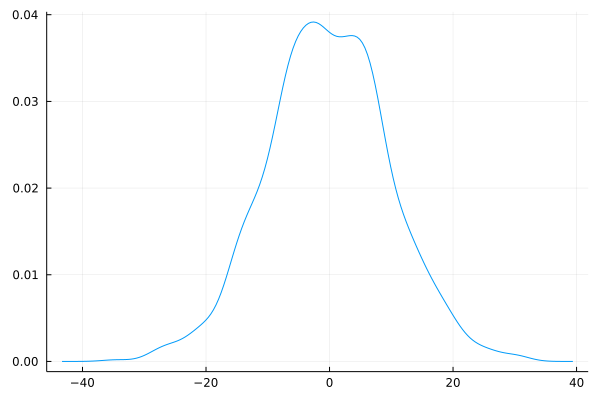

In [13]:
density(y)

## 4M2

In [17]:
@model function model_4m2(y)
    μ ~ Normal(0, 10)
    σ ~ Exponential(1)
    for i ∈ eachindex(y)
        y[i] ~ Normal(μ, σ)
    end
end

model_4m2 (generic function with 1 method)

## 4M3

```
σ ~ Exponential(1)
a ~ Uniform(0, 10)
b ~ Uniform(0, 1)
μᵢ = a + b⋅xᵢ
yᵢ ~ Normal(μ, σ)
```

## 4M4

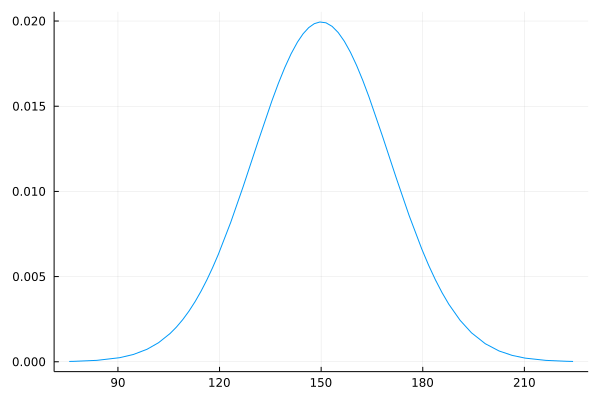

In [45]:
plot(Normal(150, 20))

Model

```
a ~ Normal(150, 20)
b ~ Uniform(-10, 10)
μ = a + b * year
σ ~ Exponential(1)
height ~ Normal(μ, σ)
```

## 4M5

I'd replace prior for b with `Uniform(0, 10)`

## 4M6

If variance is not larger than 64 cm, then we can decrease sigma in prior for a with `Normal(150, √64)`

## 4M7

In [19]:
d = DataFrame(CSV.File("../data/Howell1.csv"));
d2 = d[d.age .>= 18,:]

@model function height_regr_model(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * weight
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3 = sample(height_regr_model(d2.weight, d2.height), NUTS(0.65; init_ϵ=0.025), 1000)
m4_3 = resetrange(m4_3);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [20]:
m4_3

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.73 seconds
Compute duration  = 2.73 seconds
parameters        = a, b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           a   114.7105    1.9806     0.0626    0.1065   324.9837    1.0050    ⋯
           b     0.8870    0.0433     0.0014    0.0023   332.3107    1.0041    ⋯
           σ     5.1113    0.2089     0.0066    0.0082   400.7643    0.9991    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%    

In [22]:
m4_3_df = DataFrame(m4_3)
precis(m4_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%      50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 114.71  1.9806  111.434  114.748   117.8  ▁▁▁▃▄▇██▅▃▂▁▁ │
│     b │  0.887  0.0433   0.8195   0.8861  0.9593         ▁▄█▆▂▁ │
│     σ │ 5.1113  0.2089    4.785    5.106  5.4651  ▁▁▂▄▆██▆▄▃▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


In [23]:
extrema(d2.weight)

(31.071052, 62.992589)

In [28]:
weight_seq = 25:70
μ = StatisticalRethinking.link(m4_3_df, [:a :b], weight_seq);
μ = hcat(μ...);

In [29]:
μ_mean = mean.(eachcol(μ))
μ_PI = percentile.(eachcol(μ), ([5.5, 94.5],))
μ_PI = vcat(μ_PI'...);

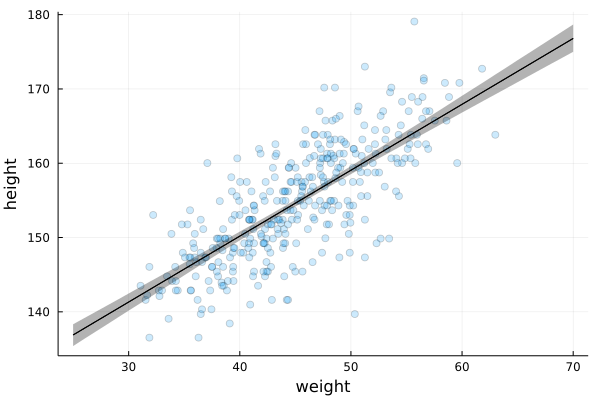

In [30]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)

Conclusion: model is almost the same, but uncertainy on model's bias is higer

In [32]:
sim_height = simulate(m4_3_df, [:a, :b, :σ], weight_seq);

In [33]:
height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

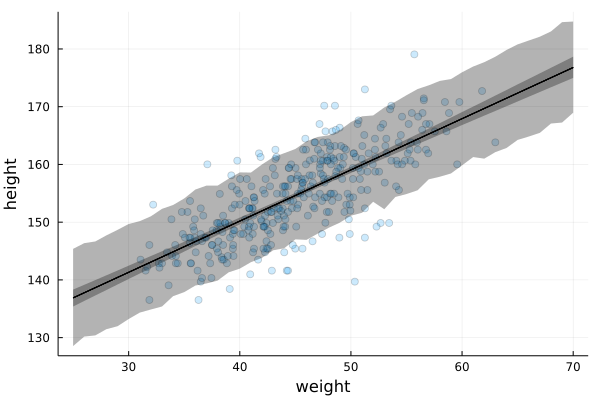

In [34]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

## 4M8

In [40]:
d = DataFrame(CSV.File("../data/cherry_blossoms.csv", missingstring="NA"));
d2 = d[completecases(d[!,[:doy]]),:]
d2 = disallowmissing(d2[!,[:year,:doy]])

num_knots = 30

knots_list = quantile(d2.year, range(0, 1; length=num_knots))
basis = BSplineBasis(3, knots_list);

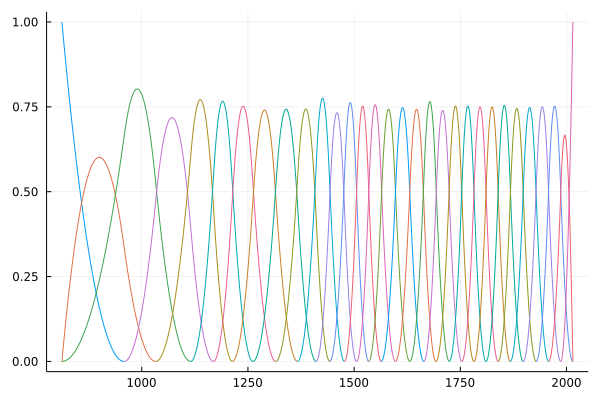

In [41]:
plot(basis; legend=false)

In [42]:
@model function model_splines(year, doy)
    w ~ MvNormal(zeros(length(basis)), 1)
    a ~ Normal(100, 10)
    s = Spline(basis, w)
    μ = a .+ s.(year)
    σ ~ Exponential(1)
    doy ~ MvNormal(μ, σ)
end

m4_7 = sample(model_splines(d2.year, d2.doy), NUTS(0.65), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shmuma/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shmuma/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shmuma/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shmuma/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, f

Chains MCMC chain (1000×45×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 18.5 seconds
Compute duration  = 18.5 seconds
parameters        = w[1], w[30], w[21], w[17], w[29], w[13], w[25], σ, w[3], w[12], w[8], w[10], w[14], w[22], w[11], w[9], w[20], w[24], w[18], w[26], w[16], a, w[2], w[4], w[19], w[27], w[6], w[23], w[5], w[28], w[7], w[15], w[31]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        w[1]   -0.4915    0.9220     0.0292    0.0225   2664.3009    0.9990    ⋯
        w[2]   -0.7456    0.8901     0.0281    0.0169   1919.3166    0.9996    ⋯
        w[3]   -0.6047  

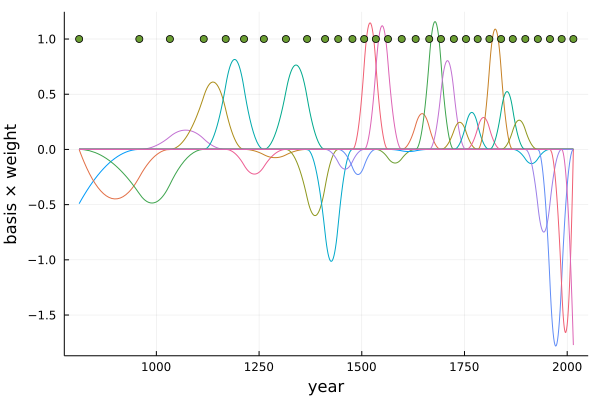

In [43]:
post = DataFrame(m4_7)

# convert columns w[*] into single column w
w_df = DataFrames.select(post, r"w")
post = DataFrames.select(post, Not(r"w"))
post[!,:w] = Vector.(eachrow(w_df))

# vector of 16 average w values
w_mean = mean.(eachcol(w_df))
p2 = plot(basis .* w_mean)
scatter!(knots_list, repeat([1], num_knots); xlab="year", ylab="basis × weight")

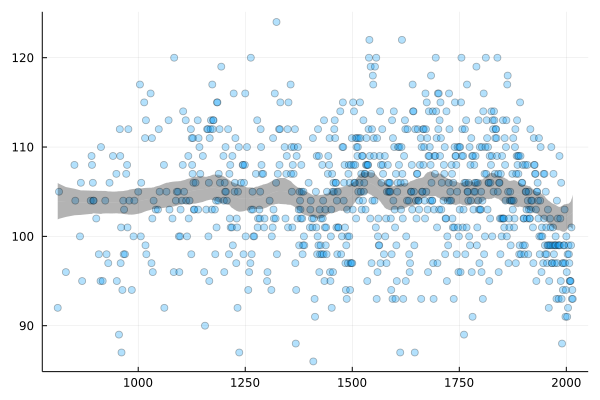

In [44]:
# explicit link logic
μ = [
    row.a .+ Spline(basis, row.w).(d2.year)
    for row ∈ eachrow(post)
]
μ = hcat(μ...);

μ_PI = percentile.(eachrow(μ), ([1.5, 98.5],))
μ_PI = vcat(μ_PI'...);

p3 = @df d2 scatter(:year, :doy; alpha=0.3)
μ_mean = mean.(eachrow(μ_PI))
plot!(d2.year, [μ_mean, μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3, alpha=0)

Conclusion: more flexibility lead to more curvy spline fitted. Not very surprising :)

# Hard problems